# Sentiment Analysis

This notebook tests the performance of various libraries for conducting sentiment analysis on text. Sentiment analysis uses automated techniques to determine whether the overall sentiment of a given text is positive, negative, or neutral. 

The training and testing datasets contain a broad range of Tweets and come from Kaggle's [Tweet Sentiment Extraction](https://www.kaggle.com/c/tweet-sentiment-extraction) competition.

In [1]:
# import libraries
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import string
import contractions
import nltk
from nltk.corpus import stopwords
import spacy

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

## Read in Data

#### Training Data

In [2]:
# read in training data
df_train = pd.read_csv('train.csv')

In [3]:
# preview training data
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
# get info about training data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


Based on the results above, there is a null row. We remove it from the data.

In [5]:
# remove null values
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


#### Testing Data

In [6]:
# read in testing data
df_test = pd.read_csv('test.csv')

In [7]:
# preview testing data
df_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [8]:
# get info about testing data
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


## Exploratory Data Analysis

#### Distribution of Tweets by Sentiment

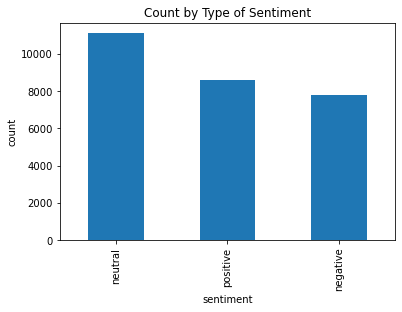

In [9]:
# breakdown of training data by sentiment count
df_train['sentiment'].value_counts().plot(kind='bar')
plt.xlabel('sentiment')
plt.ylabel('count')
plt.title('Count by Type of Sentiment')
plt.show()

In [10]:
# check percentages of sentiment count
df_train['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

We have more neutral Tweets (40.5%), but there is a similar amount of positive (31.2%) and negative (28.3%) Tweets.

#### Tweet Length by Sentiment

In [11]:
# calculate tweet length
df_train['len'] = df_train['text'].str.split().apply(len)

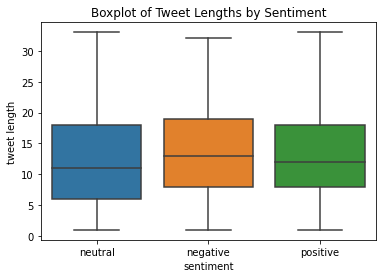

In [12]:
# check distribution of tweet length
sns.boxplot(x='sentiment', y='len', data=df_train)
plt.xlabel('sentiment')
plt.ylabel('tweet length')
plt.title('Boxplot of Tweet Lengths by Sentiment')
plt.show()

The length of tweets by sentiment is comparable, with the median length for negative tweets being ever so slightly longer.

#### Word Clouds

We use word clouds to display the words most common to each sentiment.

In [13]:
def make_word_cloud(df, sentiment):
    """
    purpose: to make a word cloud from the text in the dataframe provided where sentiment is as specified
    param df: pandas dataframe --> DF with text to feed into word cloud
          sentiment: str --> sentiment to match in 'sentiment col'
    return wc: WordCloud object
    """
    text = ' '.join(df[df['sentiment']==sentiment]['text'])  # prepare data for WordCloud by joining together values (strings) in each row
    wc = WordCloud().generate(text)  # create WordCloud using text as input
    
    return wc

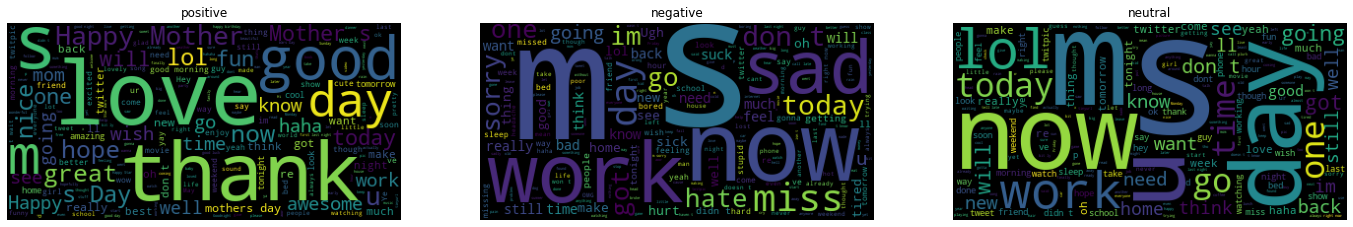

In [14]:
# display wordclouds
fig = plt.figure(figsize=(24, 24))
count = 0
for sentiment in ['positive', 'negative', 'neutral']:
    count+=1
    ax = fig.add_subplot(1, 3, count)
    wordcloud = make_word_cloud(df_train, sentiment)
    ax.imshow(wordcloud)
    ax.title.set_text(sentiment)
    ax.axis('off')

## Break Off Labels from Text

In [15]:
# break off labels from text in training data
df_train_labels = df_train[['selected_text', 'sentiment']]
df_train.drop(columns=['selected_text', 'sentiment'], inplace=True)

In [16]:
# break off labels from text in testing data
df_test_labels = df_test['sentiment'].to_frame(name='sentiment')
df_test.drop(columns=['sentiment'], inplace=True)

## Clean Text

In [17]:
def clean_text(text):
    """
    purpose: to standardize text and to remove unnecessary tokens and characters for NLP 
    param text: str --> text of Tweet
    return clean_text: str --> cleaned text of Tweet
    """
    text = re.sub("`", "'", text)  # replace backtick with single quotation mark
    text = contractions.fix(text)  # fix contractions in text
    text = text.strip()  # remove leading and trailing whitespace from text
    doc = sp_model(text)  # apply spaCy model to text
    tokens = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']  # convert text into lemmatized tokens / remove pronouns
    
    clean_tokens = [token.lower() for token in tokens]  # lowercase
    clean_tokens = [re.sub('@\S+', '', token) for token in clean_tokens]  # remove Twitter handles
    clean_tokens = [re.sub('#\S+', '', token) for token in clean_tokens]  # remove Twitter hashtags
    clean_tokens = [re.sub('(www\.\S+)|(https?:\S+)', '', token) for token in clean_tokens]  # remove websites
    clean_tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in clean_tokens]  # remove punctuation
    clean_tokens = [token.translate(str.maketrans('', '', string.digits)) for token in clean_tokens]  # remove numeric digits
    clean_tokens = [token for token in clean_tokens if token not in stopwords.words('english')]  # remove stopwords
    
    clean_text = ' '.join(clean_tokens)  # join tokens back into a string
    
    return clean_text

In [18]:
# load spaCy model
sp_model = spacy.load('en_core_web_sm')

#### Clean Training Data

In [19]:
# clean text in training data
df_train['clean'] = df_train['text'].apply(clean_text)

In [20]:
# preview training data
df_train.head()

,textID,text,len,clean
0,cb774db0d1,"I`d have responded, if I were going",7,would respond go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,10,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,5,boss bully
3,9642c003ef,what interview! leave me alone,5,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",14,son could put release already buy


In [83]:
# save cleaned data to file
df_train.to_csv('train_clean.csv')

#### Clean Testing Data

In [21]:
# clean text in testing data
df_test['clean'] = df_test['text'].apply(clean_text)

In [22]:
df_test.head()

,textID,text,clean
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,last session day
1,96d74cb729,Shanghai is also really exciting (precisely -...,shanghai also really exciting precisely skys...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",recession hit veronique branquinho quit compa...
3,01082688c6,happy bday!,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,like


In [106]:
# save cleaned data to file
df_test.to_csv('test_clean.csv')

## Conduct Sentiment Analysis

### Rule-Based

A rule-based approach to sentiment analysis uses a lexicon (or set of rules) in which words are classified as positive, negative, or neutral. More sophisticated lexicons will also include the intensity measure of a particular sentiment.

Libraries that take a rule-based approach to sentiment analysis include the following:

 - VADER
 - TextBlob

#### VADER (Valence Aware Dictionary and sEntiment Reasoner)

VADER is a rule-based sentiment analysis tool within the NLTK library. It is pretrained and works best for language in social media, e.g., short sentences. Because it is pretrained, we can apply it directly to the testing data without having to train a model. After processing a given text, VADER returns a dictionary regarding the text's sentiment, including the score as a float between -1 (negative) and +1 (positive) (saved to the 'compound' key).

In [23]:
def get_sentiment(score):
    """
    purpose: to apply a sentiment to a numeric score between -1 (negative) and +1 (positive)
    param score: int --> received after analyzing sentiment
    return str --> 'positive', 'negative', or 'neutral' based on sentiment of Tweet
    """
    # determine if score is positive, negative, or neutral
    if score >= 0.1:
        return 'positive'
    
    elif score <= -0.1:
        return 'negative'
    
    else:
        return 'neutral'

In [24]:
# initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

In [25]:
def vader_score(text):
    """
    purpose: to determine the general sentiment of a Tweet using the pretrained VADER tool
    param text: str --> text of Tweet to analyze
    return str --> 'positive', 'negative', or 'neutral' based on sentiment of Tweet
    """
    # calculate sentiment scores
    v_score = vader.polarity_scores(text)
    
    return get_sentiment(v_score['compound'])

In [26]:
df_test_labels['vader'] = df_test['clean'].apply(vader_score)

#### TextBlob

TextBlob is also a rule-based sentiment analysis tool built upon NLTK and Pattern. TextBlob offers a simple API through which users can access natural language processing tasks such as noun phrase extraction, part-of-speech tagging, and sentiment analysis. The sentiment analyzer returns two properties for an input string:

 - **Polarity**: A float between -1 (negative) and +1 (positive) characterizing sentiment
 - **Subjectivity**: A float between 0 (objective) and 1 (subjective) regarding how objective a string is
 
For our purposes, we will be looking at the polarity score.

In [27]:
def textblob_score(text):
    """
    purpose: to determine the general sentiment of a Tweet using the pretrained VADER tool
    param text: str --> text of Tweet to analyze
    return str --> 'positive', 'negative', or 'neutral' based on sentiment of Tweet
    """
    # calculate sentiment scores
    tblob_score = TextBlob(text).sentiment.polarity
    
    return get_sentiment(tblob_score)

In [28]:
df_test_labels['tblob'] = df_test['clean'].apply(textblob_score)

In [47]:
df_test_labels.head(10)

,sentiment,vader,tblob
0,neutral,neutral,neutral
1,positive,positive,positive
2,negative,negative,neutral
3,positive,positive,positive
4,positive,positive,neutral
5,positive,positive,positive
6,negative,negative,neutral
7,negative,negative,positive
8,neutral,neutral,neutral
9,neutral,positive,neutral


### Machine Learning-Based

In addition to rule-based sentiment analysis, one can use sentiment analysis with machine learning (including deep learning). Libraries to try:

 - BERT
 - RoBERTa?
 - spaCy
 - Dependency Parser
 - Flair